<a href="https://colab.research.google.com/github/sofiaborgato/Bioinformatic_project/blob/main/LSTM%2Cnot_aligned_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset, Imports, Usefull Function

In [ ]:
#Libraries imported
import sys
import os
import numpy as np
import string
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [ ]:
def wrong_basis(text):
    chars = ['N','R','Y','K','M','S','W','B','D','H','V']
    for c in chars:
        text = text.replace(c,'X')
    return text

In [ ]:
def read(path):
    reads=[] #array of the reads to be returned
    bases = ['A','C','G','T']
    copy = True
    with open(path) as f:
        genome = ""
        for line in f:
            if line[0] != '>':
                row=line.replace('\n','')
                genome = genome + row

            #By setting the flag the next line will be appended to the array
            if line[0] == '>' and len(genome)!=0:
              genome=wrong_basis(genome)
              genome=genome.upper()
              reads.append(genome)
              genome=""
            
    return reads

In [ ]:
usa = read('cal.fasta')
braz = read('brazil.fasta')
original = read('original.fasta')
eng = read('eng1.fasta')
eng_2 = read('eng2.fasta')
sa=read('sa.fasta')

In [ ]:
us=pd.DataFrame()
us['genome']=usa
label_usa=np.ones(len(us))
us['label']=label_usa

bra=pd.DataFrame()
bra['genome']=braz
label_bra=np.ones(len(bra))*2
bra['label']=label_bra

ori=pd.DataFrame()
ori['genome']=original
label_ori=np.zeros(len(ori))
ori['label']=label_ori

e_1=pd.DataFrame()
e_1['genome']=eng
label_e_1=np.ones(len(e_1))*3
e_1['label']=label_e_1

e_2=pd.DataFrame()
e_2['genome']=eng_2
label_e_2=np.ones(len(e_2))*4
e_2['label']=label_e_2

afri=pd.DataFrame()
afri['genome']=sa
label_afri=np.ones(len(afri))*5
afri['label']=label_afri

In [ ]:
def kmer_from_sequence(sequence):
  k=7
  kmers = str()
  for i in range(0, len(sequence)-k+1):
      kmer = sequence[i:i + k]+" "
      kmers+=kmer+" "
    
  return kmers

In [ ]:
us=pd.DataFrame()
us['genome']=usa
label_usa=np.ones(len(us))
us['label']=label_usa
us['genome']=us['genome'].apply(kmer_from_sequence)

bra=pd.DataFrame()
bra['genome']=braz
label_bra=np.ones(len(bra))*2
bra['label']=label_bra
bra['genome']=bra['genome'].apply(kmer_from_sequence)

ori=pd.DataFrame()
ori['genome']=original
label_ori=np.zeros(len(ori))
ori['label']=label_ori
ori['genome']=ori['genome'].apply(kmer_from_sequence)

e_1=pd.DataFrame()
e_1['genome']=eng
label_e_1=np.ones(len(e_1))*3
e_1['label']=label_e_1
e_1['genome']=e_1['genome'].apply(kmer_from_sequence)

e_2=pd.DataFrame()
e_2['genome']=eng_2
label_e_2=np.ones(len(e_2))*4
e_2['label']=label_e_2
e_2['genome']=e_2['genome'].apply(kmer_from_sequence)

afri=pd.DataFrame()
afri['genome']=sa
label_afri=np.ones(len(afri))*5
afri['label']=label_afri
afri['genome']=afri['genome'].apply(kmer_from_sequence)




In [ ]:
X='X'
stat=[]
for el in e_2['genome']:
  num_X = el.count(X)
  stat.append(num_X)
s = np.array(stat)
e_2 = e_2[s<350]

In [ ]:
len(e_2)

1015

In [ ]:
n_samples = 1000

us=us.sample(n = n_samples)
ori=ori.sample(n = n_samples)
bra=bra.sample(n = n_samples)
e_1=e_1.sample(n = n_samples)
e_2=e_2.sample(n = n_samples)
afri=afri.sample(n = n_samples)

In [ ]:
datasets=[us,ori,bra,e_1,e_2,afri]
total=pd.concat(datasets)


In [ ]:
total['label'] = total['label'].astype("int")
total['label'] = total['label'].astype("category")

In [ ]:
us.to_csv("us.csv",index = False)
ori.to_csv("ori.csv",index = False)
bra.to_csv("bra.csv",index = False)
e_1.to_csv("e_1.csv",index = False)
e_2.to_csv("e_2.csv",index = False)
afri.to_csv("afri.csv",index = False)

In [ ]:
total.to_csv("total.csv", index=False)

# Preprocessing

## One Hot Encodiging of the 6 possible Label

In [ ]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(total['label'])

#One hot ecoding
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
label = ohe.fit_transform(integer_encoded)



In [ ]:
len(total['genome'])

2400

## Train,Val,Test Split with stratification among labels values


In [ ]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(total['genome'],label, test_size=0.1, shuffle=True, stratify=label)
train_x, val_x,train_y,val_y = train_test_split(train_x,train_y, test_size=0.3,shuffle=True, stratify=train_y)


In [ ]:
print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)

print(test_x.shape)
print(test_y.shape)



(1512,)
(1512, 6)
(648,)
(648, 6)
(240,)
(240, 6)


## Tokenization of the genomic sequence 

Each line of the datsets is splitted in char, a vocabulary of 5 values is created, and the index of the basis in the vocabulary is used to trasform each alphabetics sequnquence in a numeric sequence.

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size=20000

In [ ]:
tokenizer = Tokenizer(char_level=False,num_words=vocab_size)
tokenizer.fit_on_texts(total['genome'])

In [ ]:
word_index = tokenizer.word_index
len(word_index)

25759

In [ ]:
word_index.items()


dict_items([('xxxxxxx', 1), ('ttgttaa', 2), ('tggtgtt', 3), ('aattgtt', 4), ('tgctgct', 5), ('tggtgat', 6), ('gaagaag', 7), ('aaattgt', 8), ('tgtttta', 9), ('ttcaact', 10), ('tactaat', 11), ('tgttaat', 12), ('taatggt', 13), ('tgatggt', 14), ('tgttaaa', 15), ('tttacaa', 16), ('ttgttac', 17), ('ttacaaa', 18), ('tgaagaa', 19), ('ttaaaaa', 20), ('tttatga', 21), ('ttttgct', 22), ('tgatgtt', 23), ('ttttgtt', 24), ('tgttgtt', 25), ('aaaagaa', 26), ('ttcttta', 27), ('tgttctt', 28), ('tttggtg', 29), ('tattgtt', 30), ('attgtta', 31), ('ggtgttt', 32), ('aacaatg', 33), ('gttttaa', 34), ('tgctgtt', 35), ('tttgtta', 36), ('ttactaa', 37), ('gctgttg', 38), ('tttctta', 39), ('aaagaaa', 40), ('aacaact', 41), ('gtgttgt', 42), ('attttgt', 43), ('tgttact', 44), ('acaaatt', 45), ('atggtgt', 46), ('cttttga', 47), ('agctggt', 48), ('gcttttg', 49), ('acttatg', 50), ('ggtgttg', 51), ('tgtttat', 52), ('catttgt', 53), ('ttacttt', 54), ('tgttggt', 55), ('actttta', 56), ('ctggtaa', 57), ('cttatgt', 58), ('attgttg',

## Padding 

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences (training_sequences, padding = 'post' )
#training_sequences=tokenizer.sequences_to_texts(training_padded)


testing_sequences = tokenizer.texts_to_sequences(test_x)
print(len(testing_sequences))
testing_padded = pad_sequences(testing_sequences,padding = 'post')

val_sequences = tokenizer.texts_to_sequences(val_x)
val_padded = pad_sequences(val_sequences,padding = 'post')


240


In [ ]:
training_padded.shape

(1512, 29964)

## From padded sequences extract kmers


# RNN Model 

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

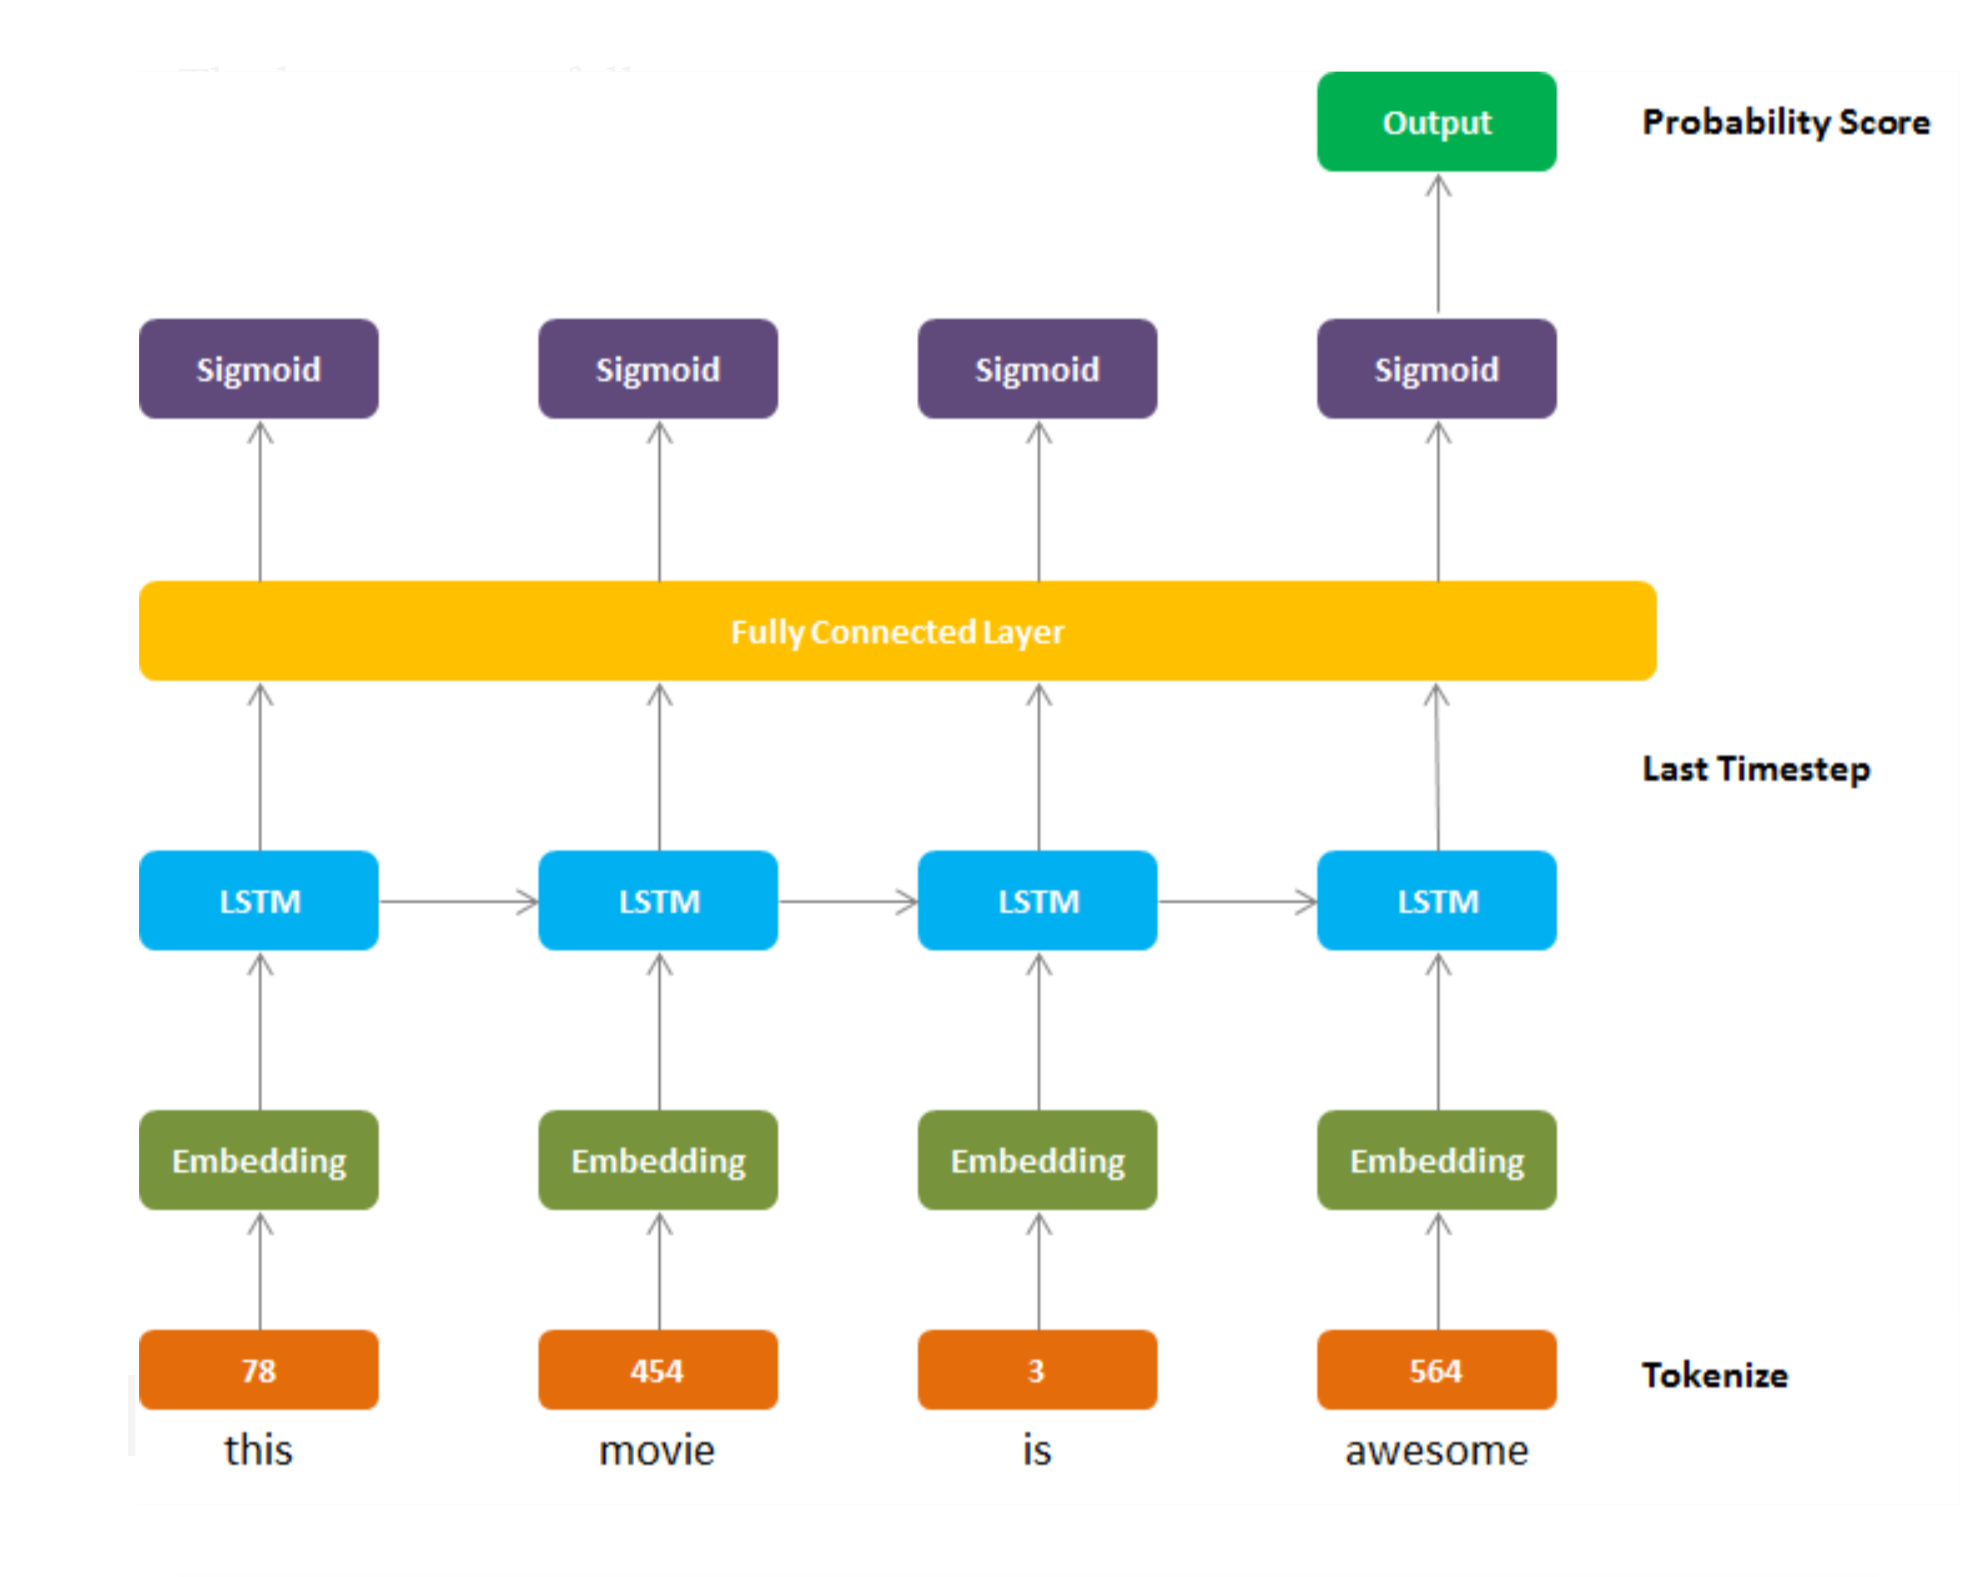

Structure for the model :
* Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
* An embedding layer that converts our word tokens (integers) into embeddings of a specific size. Embedding refers to mapping a high-dimensional sparse feature vector to a dense vector with a much lower dimension. The embedding layer in TensorFlow is just like a look-up table.
* A dropout layer is used to reduce overfitting of the data
* A Conv1D layer 
* Max Pooling Layer
* An LSTM layer defined by a hidden_state size and number of layers
* Output: Dense Layer

In [ ]:
#LSTM hyperparameters
#n_lstm = 20
drop_lstm =0.2
embedding_dim = 1000
#alzare dimesione
max_length = 32

#LSTM architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(600,7),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(600),
    tf.keras.layers.Dense(600, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(60, activation='sigmoid'),
    tf.keras.layers.Dense(6,activation='sigmoid')
])
optimizer=keras.optimizers.Adam(learning_rate=0.01)

In [ ]:


model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

num_epochs = 30

training_padded = np.array(training_padded)
training_labels = np.array(train_y)
val_padded = np.array(val_padded)
val_labels = np.array(val_y)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(val_padded, val_labels), verbose=2,batch_size=8)






print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 1000)          20000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 600)           4200600   
_________________________________________________________________
dropout (Dropout)            (None, 26, 600)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 600)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 600)               2882400   
_________________________________________________________________
dense (Dense)                (None, 600)               360600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6

## Result Plot 

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#Result Visulization
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend([" Train Accuracy", "Validation Accuracy"])

plt.figure()


# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend([" Train Loss", "Validation Loss"])

plt.figure()

## Test

In [ ]:
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_y)
score = model.evaluate(testing_padded,testing_labels, verbose = 2) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

# Second Model with customize training phase

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(training_padded)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(val_padded)), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(np.array(testing_padded)), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

#Shuffle Data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()
if(train_on_gpu):
print('Training on GPU.')
else:
print('No GPU available, training on CPU.')

In [ ]:
import torch.nn as nn

class customRNN(nn.Module):
  
    

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        
        #Initialize the model by setting up the layers.
        
        super(customRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        
        #Perform a forward pass of our model on some input and hidden state.
        
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [ ]:

output_size = 6
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = customRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [ ]:
# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))